In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.sparse import vstack
import pickle

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, precision_score
import seaborn as sns

import os

Set paths and read object:

In [2]:
path = "C:/Users/SG/hlca_core.h5ad"
results_path = "Analysis_results/"

if not os.path.exists(results_path):
    os.makedirs(results_path)

In [3]:
adata = anndata.read_h5ad(path, backed = 'r')

Import manually created color maps:

In [4]:
with open('color_mappings.pickle', 'rb') as file:
    color_mappings = pickle.load(file)

## Helper functions

#### Functions to determine proportions

In [5]:
def mod_train_clf_and_predict_equaltest(X, y, sex_labels, proportion_female, classifier='knn', k = 30):
    '''
    This is a modification of the train_clf_and_predict_equaltest function that does not actually train/predict anything.
    It only selects the training set according to proportion_female and returns it, along with the male and female test sets.
    It additionally returns the sex labels of the training set.
    ----------
    
    Parameters:
    X = expression matrix; matrix of shape n_obs x n_vars
    y = (cell type) labels; array/list of shape n_obs
    sex_labels = 'male' or 'female' label for each entry; array/list of shape n_obs
    proportion_female = desired proportion of female cells; float between 0 and 1
    classifier = 'knn', 'svm' or 'rf'
    k = value if using knn; default 30
    ----------
    
    Returns:
    X_selected, y_selected, train_sex = entries, labels and sex labels for the selected training set 
    y_female_test, y_male_test = labels for the female and male test set
    
    '''
    
    np.random.seed(42)
    
    male_indices = np.where(sex_labels == 'male')[0]
    female_indices = np.where(sex_labels == 'female')[0]

    X_male = X[male_indices]
    y_male = y[male_indices]
    X_female = X[female_indices]
    y_female = y[female_indices]
    
    
    X_female_train, X_female_test, y_female_train, y_female_test = train_test_split(
        X_female, y_female, test_size=0.2, stratify=y_female, random_state=42)
    
    # compute what to pass to test_size to get equal test set size to the female set
    male_proportion = len(X_female_test) / len(X_male)

    X_male_train, X_male_test, y_male_train, y_male_test = train_test_split(
        X_male, y_male, test_size=male_proportion, stratify=y_male, random_state=42)
    

    # merge training sets back together
    # X_train = np.concatenate([X_male_train, X_female_train])
    X_train = vstack([X_male_train, X_female_train])
    y_train = np.concatenate([y_male_train, y_female_train])
    sex_labels_train = ['male'] * X_male_train.shape[0] + ['female'] * X_female_train.shape[0]


    # select female cells based on proportion_female
    selected_indices = fixed_select_indices_by_proportion(sex_labels_train, proportion_female)
    X_selected = X_train.tocsr()[selected_indices]
    y_selected = y_train[selected_indices]
    train_sex = np.array(sex_labels_train)[selected_indices]

    return X_selected, y_selected, train_sex, y_female_test, y_male_test

In [6]:
def fixed_select_indices_by_proportion(sex_labels, proportion_female):
    '''
    Selects indices from the training set according to proportion_female. 
    The function calculates a fixed size based on the minimum class in sex_labels.
    It also shuffles the training set so as to not subset from only one part of the array.
    ---------
    
    Parameters:

    sex_labels = training set sex labels; this is the only information needed for index selection
    proportion_female = float denoting desired proportion of female cells
    
    ----------
    
    Returns: an np array containing indices, which can then be used to subset the training set.
    '''
    np.random.seed(42)
    sex_labels_series = pd.Series( (el for el in sex_labels) )
    
    female_indices = np.where(sex_labels_series == 'female')[0]
    male_indices = np.where(sex_labels_series == 'male')[0]
    
    fixed_size = min(len(female_indices), len(male_indices))
    
    np.random.shuffle(female_indices)
    np.random.shuffle(male_indices)

    num_female_cells = int(fixed_size * proportion_female)
    num_male_cells = fixed_size - num_female_cells
        # total will always be fixed_size
        # this works for cases with prop 0% or 100% --> no need to handle them separately
    
    # adjust in case of rounding errors
    num_female_cells = min(num_female_cells, len(female_indices))
    num_male_cells = min(num_male_cells, len(male_indices))

    selected_female_indices = female_indices[:num_female_cells]
    selected_male_indices = male_indices[:num_male_cells]

    return np.concatenate([selected_female_indices, selected_male_indices])

#### Functions for plotting

In [7]:
def plot_distribution(label_lists, sex_label_lists, title, colors, save = False):
    '''
    Use this for training set distribution.
    '''
    num_props = len(label_lists)
    class_labels = sorted(set(label for labels in label_lists for label in labels))
    num_classes = len(class_labels)

    class_counts = [{label: [0, 0] for label in class_labels} for _ in range(num_props)]

    props = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    label_dict = {f"prop_{props[i]}": {} for i in range(num_props)}

    # calculate class counts for each proportion
    for i, (labels, sex_labels) in enumerate(zip(label_lists, sex_label_lists)):
        for label in class_labels:
            male_count = sum((labels == label) & (sex_labels == 'male'))
            female_count = sum((labels == label) & (sex_labels == 'female'))
            class_counts[i][label] = [male_count, female_count]

            # populate label_dict with counts for each proportion
            label_dict[f"prop_{props[i]}"][label] = (male_count, female_count)

    # plotting
    fig, ax = plt.subplots(figsize=(12, 6))
    bottom = np.zeros(num_props)
    
    for i, label in enumerate(class_labels):
        total_counts = [sum(class_counts[j][label]) for j in range(num_props)]
        ax.bar(np.arange(num_props), total_counts, bottom=bottom, label=label, color=colors[i])
        bottom += total_counts
        
    ax.set_xticks(np.arange(num_props))
    ax.set_xticklabels([f"{float('{:.2f}'.format(prop))}" for prop in np.arange(0, 1.1, 0.1)])
    ax.set_xlabel('Proportion of Female Cells')
    ax.set_ylabel('Count')
    ax.set_title(title)

    handles, labels = ax.get_legend_handles_labels()
    if len(labels) > 55:
        ncol = 3
    elif len(labels) > 30:
        ncol = 2
    else:
        ncol = 1
    ax.legend(reversed(handles), reversed(labels), loc='center left', bbox_to_anchor=(1, 0.5), ncol=ncol)
    
    plt.tight_layout()
    if save:
        plt.savefig(f"{results_path}/training_{title[-1]}.png")
    plt.show()

    # return values
    return label_dict

In [8]:
def plot_grouped_distribution(male_label_list, female_label_list, title, colors, legend = False, save = False):
    '''
    Use this for test set distribution.
    '''
    class_labels = sorted(list(set(male_label_list)))
    num_classes = len(class_labels)

    class_counts = {label: [0, 0] for label in class_labels}

    for label in class_labels:
        male_count = sum((male_label_list == label))
        female_count = sum((female_label_list == label))
        class_counts[label] = [male_count, female_count]

    # Plotting
    fig, ax = plt.subplots(figsize=(4, 6))
    bottom = np.zeros(2)
    
    for i, label in enumerate(class_labels):
        ax.bar([0,1], class_counts[label], bottom=bottom, label=label, color=colors[i])
        bottom += class_counts[label]

    ax.set_xticks([0,1])
    ax.set_xticklabels(['Male', 'Female'])
    ax.set_xlabel('Sex')
    ax.set_ylabel('Count')
    ax.set_title(title)

    handles, labels = ax.get_legend_handles_labels()
    if len(labels) > 55:
        ncol = 3
    elif len(labels) > 15:
        ncol = 2
    else:
        ncol = 1

    if legend:
        ax.legend(reversed(handles), reversed(labels), loc='center left', bbox_to_anchor=(1, 0.5), ncol=ncol)
    
    plt.tight_layout()
    if save:
        plt.savefig(f"{results_path}/test_{title[-1]}.png")
    plt.show()

    return class_counts

## Determining cell type proportions

### Annotation level 2

#### Training set

In [9]:
embedding = adata.obsm['X_scanvi_emb']
sex_labels = adata.obs['sex']
cell_type_labels = adata.obs['ann_level_2'].astype(str)
classes = sorted(set(cell_type_labels), reverse = True)
label_lists2 = []
sex_label_lists2 = []
maletest_lists2 = []
femaletest_lists2 = []

for prop in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    X_selected, y_selected, train_sex, y_female_test, y_male_test = mod_train_clf_and_predict_equaltest(embedding, cell_type_labels, sex_labels, prop)
    label_lists2.append(y_selected)
    sex_label_lists2.append(train_sex)
    maletest_lists2.append(y_male_test)
    femaletest_lists2.append(y_female_test)

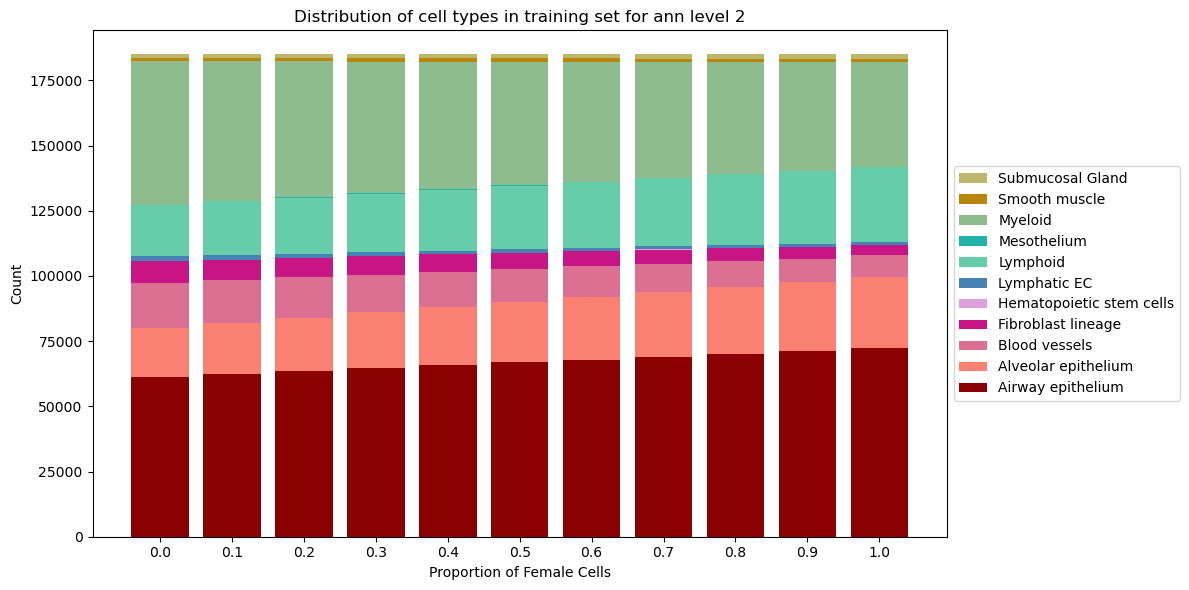

In [10]:
d2 = plot_distribution(label_lists2, sex_label_lists2, "Distribution of cell types in training set for ann level 2", list(color_mappings["ann_2"].values()))

#### Test set

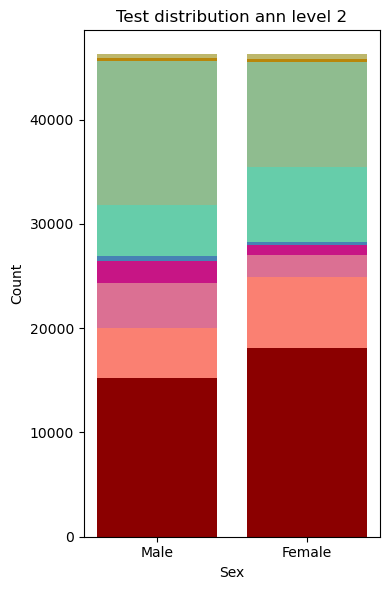

In [11]:
t2 = plot_grouped_distribution(maletest_lists2[0], femaletest_lists2[0], "Test distribution ann level 2", list(color_mappings["ann_2"].values()))

### Annotation level 3

#### Training set

In [12]:
embedding = adata.obsm['X_scanvi_emb']
sex_labels = adata.obs['sex']
cell_type_labels = adata.obs['ann_level_3'].astype(str)
cell_type_labels = cell_type_labels.where(cell_type_labels != 'None', adata.obs['ann_level_2'].astype(str))
classes = sorted(set(cell_type_labels))
label_lists3 = []
sex_label_lists3 = []
maletest_lists3 = []
femaletest_lists3 = []

for prop in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    X_selected, y_selected, train_sex, y_female_test, y_male_test = mod_train_clf_and_predict_equaltest(embedding, cell_type_labels, sex_labels, prop)
    label_lists3.append(y_selected)
    sex_label_lists3.append(train_sex)
    maletest_lists3.append(y_male_test)
    femaletest_lists3.append(y_female_test)

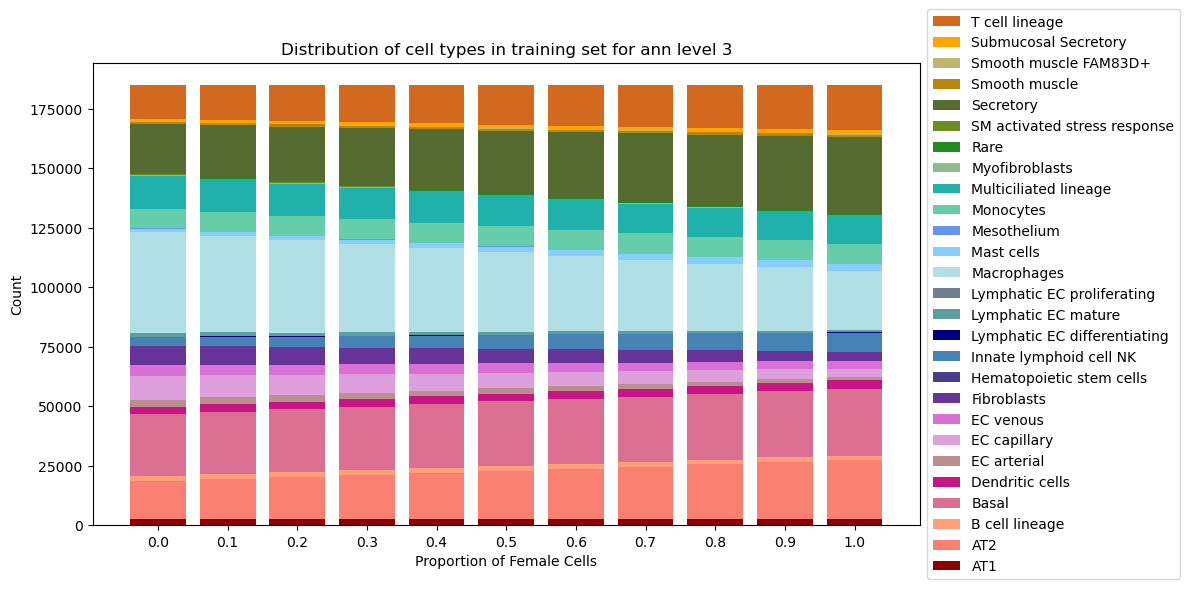

In [13]:
d3 = plot_distribution(label_lists3, sex_label_lists3, "Distribution of cell types in training set for ann level 3",  list(color_mappings["ann_3"].values()))

#### Test sets

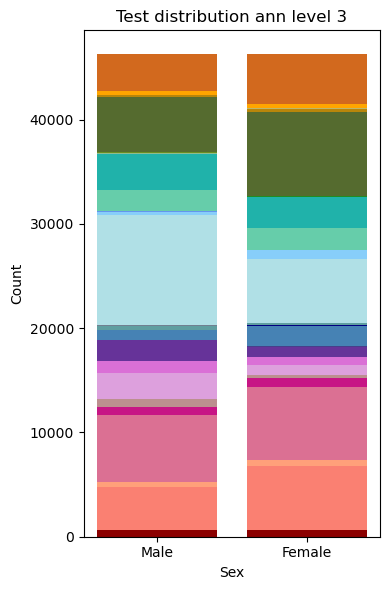

In [14]:
t3 = plot_grouped_distribution(maletest_lists3[0], femaletest_lists3[0], "Test distribution ann level 3", list(color_mappings["ann_3"].values()))

### Annotation level 4

### Training set

In [15]:
embedding = adata.obsm['X_scanvi_emb']
sex_labels = adata.obs['sex']
cell_type_labels = adata.obs['ann_level_4'].astype(str)
cell_type_labels = cell_type_labels.where(cell_type_labels != 'None', adata.obs['ann_level_3'].astype(str))
cell_type_labels = cell_type_labels.where(cell_type_labels != 'None', adata.obs['ann_level_2'].astype(str))
classes = sorted(set(cell_type_labels))
label_lists4 = []
sex_label_lists4 = []
maletest_lists4 = []
femaletest_lists4 = []

for prop in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    X_selected, y_selected, train_sex, y_female_test, y_male_test = mod_train_clf_and_predict_equaltest(embedding, cell_type_labels, sex_labels, prop)
    label_lists4.append(y_selected)
    sex_label_lists4.append(train_sex)
    maletest_lists4.append(y_male_test)
    femaletest_lists4.append(y_female_test)

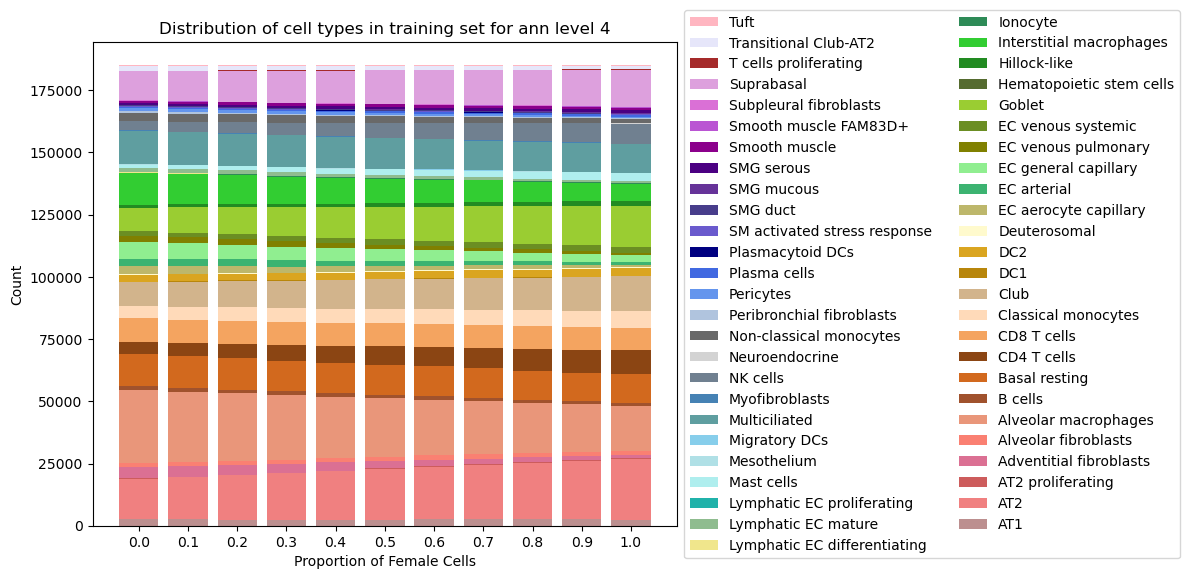

In [16]:
d4 = plot_distribution(label_lists4, sex_label_lists4, "Distribution of cell types in training set for ann level 4",  list(color_mappings["ann_4"].values()))

#### Test sets

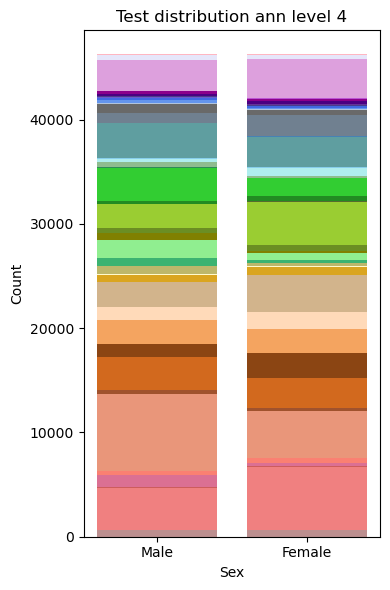

In [17]:
t4 = plot_grouped_distribution(maletest_lists4[0], femaletest_lists4[0], "Test distribution ann level 4", list(color_mappings["ann_4"].values()))

### Ann finest level

#### Training set

In [18]:
embedding = adata.obsm['X_scanvi_emb']
sex_labels = adata.obs['sex']
cell_type_labels = adata.obs['ann_finest_level'].astype(str)
classes = sorted(set(cell_type_labels))
label_lists5 = []
sex_label_lists5 = []
maletest_lists5 = []
femaletest_lists5 = []

for prop in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    X_selected, y_selected, train_sex, y_female_test, y_male_test = mod_train_clf_and_predict_equaltest(embedding, cell_type_labels, sex_labels, prop)
    label_lists5.append(y_selected)
    sex_label_lists5.append(train_sex)
    maletest_lists5.append(y_male_test)
    femaletest_lists5.append(y_female_test)

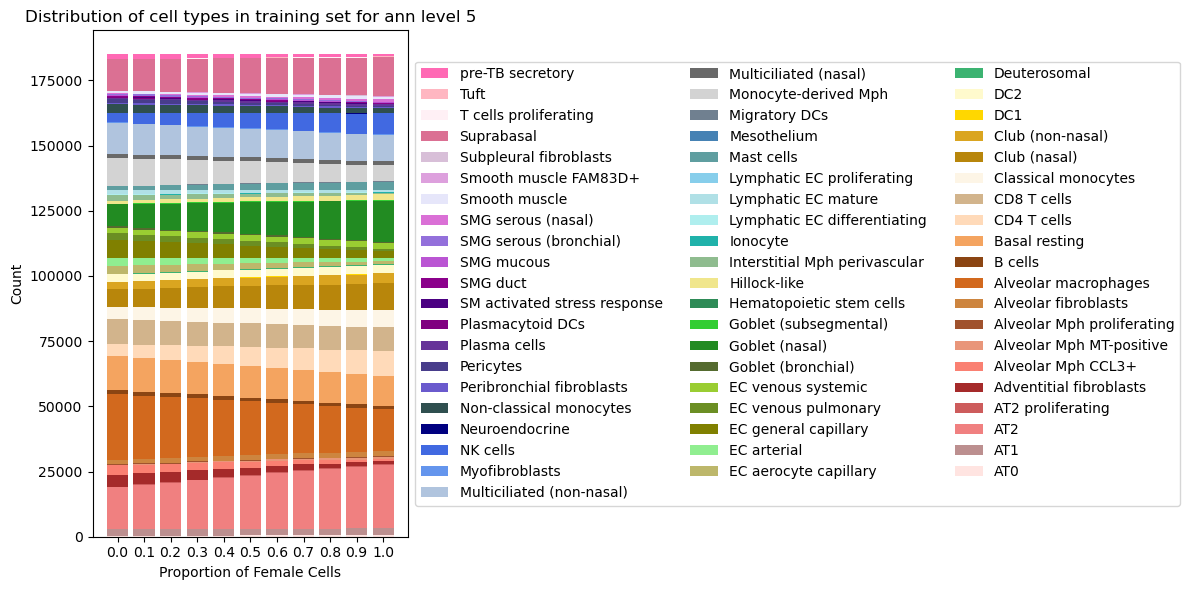

In [19]:
d5 = plot_distribution(label_lists5, sex_label_lists5, "Distribution of cell types in training set for ann level 5",  list(color_mappings["ann_finest"].values()))

#### Test sets

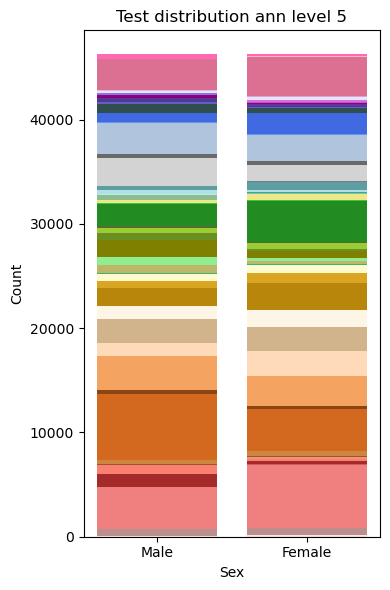

In [20]:
t5 = plot_grouped_distribution(maletest_lists5[0], femaletest_lists5[0], "Test distribution ann level 5", list(color_mappings["ann_finest"].values()))

## Export all results

In [21]:
def extract_sexes(test_dict):
    return dict([(key, item[0]) for key, item in t2.items()]), dict([(key, item[0]) for key, item in t2.items()])

In [22]:
proportions = dict()
proportions["training_sets"] = {"ann_2": d2, "ann_3": d3, "ann_4": d4, "ann_finest": d5}
proportions["male_test_sets"] = {"ann_2": extract_sexes(t2)[0], "ann_3": extract_sexes(t3)[0], "ann_4": extract_sexes(t4)[0], "ann_finest": extract_sexes(t5)[0]}
proportions["female_test_sets"] = {"ann_2": extract_sexes(t2)[1], "ann_3": extract_sexes(t3)[1], "ann_4": extract_sexes(t4)[1], "ann_finest": extract_sexes(t5)[1]}

with open(f'{results_path}proportion_dictionary.pickle', 'wb') as file:
    pickle.dump(proportions, file)